In [ ]:
import requests
import time
import pandas as pd
from tqdm.auto import tqdm
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

In [ ]:
# Read the TSV file into a pandas DataFrame
df = pd.read_csv('moviereviews.tsv', sep='\t')

df

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...
...,...,...
1995,pos,"i like movies with albert brooks , and i reall..."
1996,pos,it might surprise some to know that joel and e...
1997,pos,the verdict : spine-chilling drama from horror...
1998,pos,i want to correct what i wrote in a former ret...


In [ ]:
# Keep punctuation like exclamation marks, question marks, and common sentence delimiters
clean_text = lambda text: re.sub(r'[^a-zA-Z\s\.\!\?]', '', text.lower()).strip() if pd.notna(text) else text

df['review'] = df['review'].apply(clean_text)

# Drop NaN values
df.dropna(subset=['review'], inplace=True)

# Filter out rows where the review column is empty or contains just whitespace
df = df[df['review'].str.strip().astype(bool)]

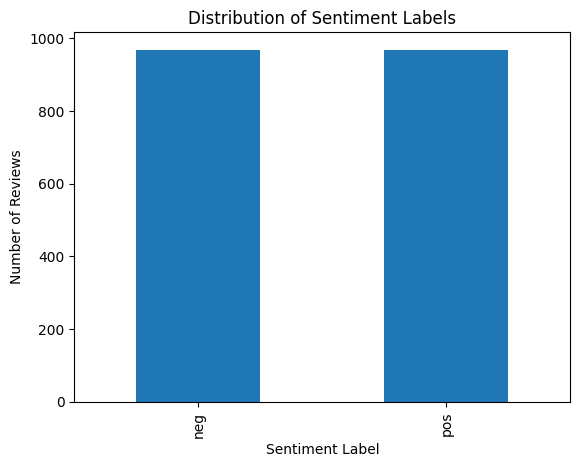

In [ ]:
# Visualize the label distribution with a bar chart
label_counts = df['label'].value_counts()
label_counts.plot(kind='bar')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiment Labels')
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


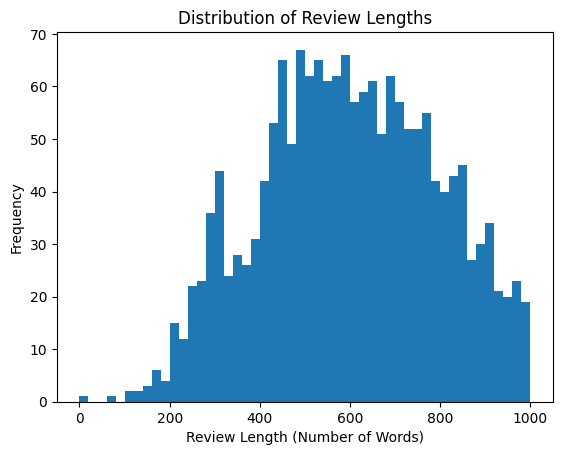

In [ ]:
nltk.download('punkt')

# Calculate the length of each review and plot a histogram
df_clean = df.copy()
df_clean['review_length'] = df_clean['review'].apply(lambda x: len(word_tokenize(x)) if pd.notna(x) else 0)
df_clean['review_length'].plot(kind='hist', bins=50, range=(0, 1000))
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


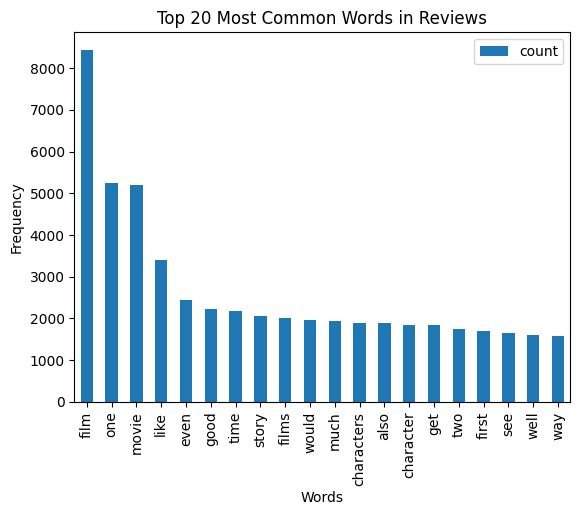

In [ ]:
nltk.download('stopwords')

# Tokenize the reviews, filter out stopwords and non-alphabetic words, and flatten the list
tokens = df['review'].dropna().apply(word_tokenize)
tokens = tokens.apply(lambda words: [word.lower() for word in words if word.isalpha()])
stop_words = set(stopwords.words('english'))
tokens = tokens.apply(lambda words: [word for word in words if word not in stop_words])

# Flatten the list of lists into a single list of tokens
all_words = [word for token_list in tokens for word in token_list]

# Count the frequency of each word
word_freq = Counter(all_words)

# Visualize the most common words
common_words = word_freq.most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

common_words_df.plot(kind='bar', x='word', y='count')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in Reviews')
plt.xticks(rotation=90)
plt.show()

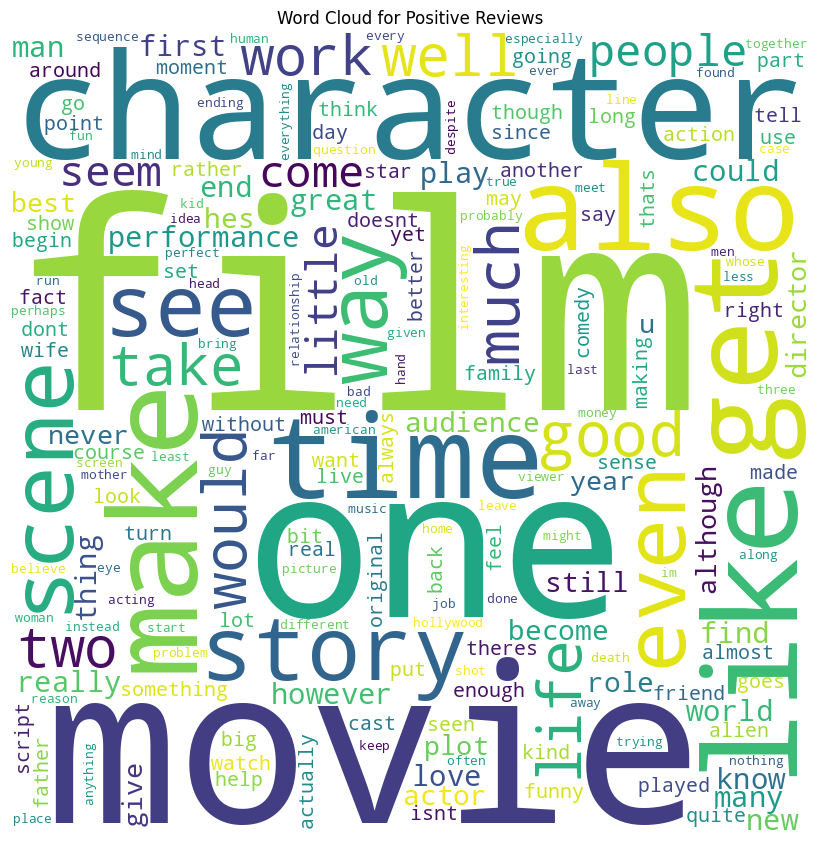

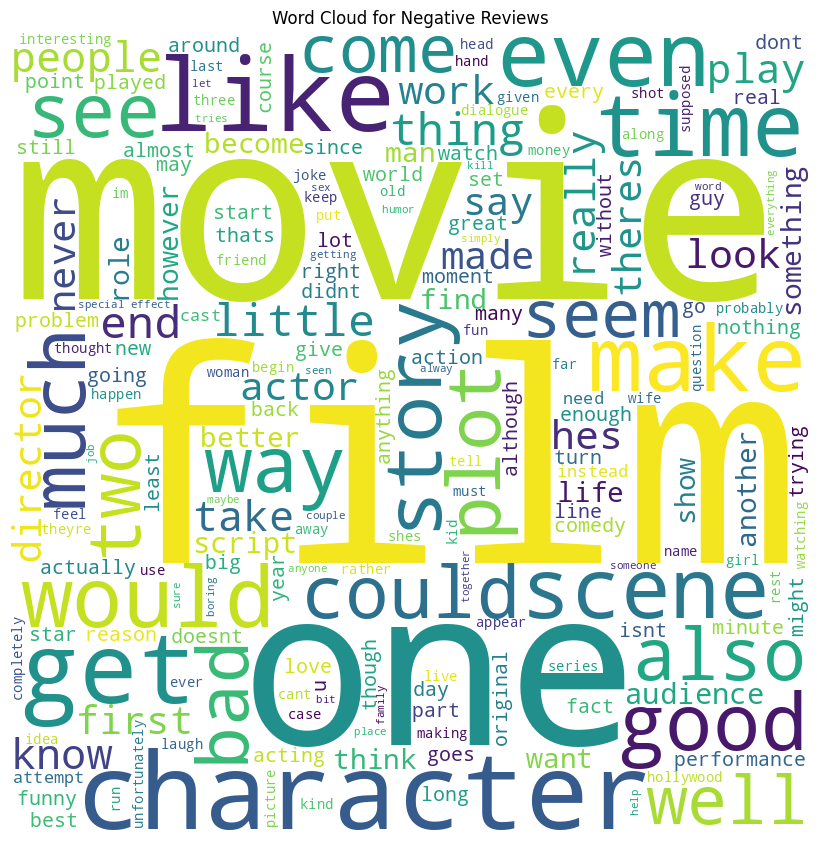

In [ ]:
from wordcloud import WordCloud

# Split the reviews into positive and negative based on the sentiment label
positive_reviews = df[df['label'] == 'pos']['review'].str.cat(sep=' ')
negative_reviews = df[df['label'] == 'neg']['review'].str.cat(sep=' ')

# Generate word clouds
wordcloud_pos = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          stopwords = stop_words,
                          min_font_size = 10).generate(positive_reviews)

wordcloud_neg = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          stopwords = stop_words,
                          min_font_size = 10).generate(negative_reviews)

# Display the positive WordCloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud for Positive Reviews')
plt.show()

print()

# Display the negative WordCloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud for Negative Reviews')
plt.show()

In [ ]:
df

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of and already ive g...
...,...,...
1995,pos,i like movies with albert brooks and i really...
1996,pos,it might surprise some to know that joel and e...
1997,pos,the verdict spinechilling drama from horror m...
1998,pos,i want to correct what i wrote in a former ret...


In [ ]:
# Replace with actual API URL
base_api_url = 'https://scheduled-manufacturers-drinking-sci.trycloudflare.com/api/v1'

In [ ]:
# Function that gets the model's name
def get_current_model(base_api_url):

    model_url = base_api_url + '/model'

    try:
        response = requests.get(model_url)
        response.raise_for_status()
        model = response.json()['result']
        print(f"The current model used is: {model}")
        return model

    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")

    except requests.exceptions.RequestException as e:
        print(f"Request exception occurred: {e}")

    except ValueError as e:
        print(f"JSON decoding failed: {e}")

# Get and print the current model
current_model = get_current_model(base_api_url)


The current model used is: Mistral-7B-Instruct-v0.1-GPTQ


In [ ]:
# Function to extract the sentiment
def extract_sentiment(generated_text):
    lower_text = generated_text.lower()

    sentiments = {
        "positive": "pos",
        "negative": "neg"
    }

    for sentiment, abbreviation in sentiments.items():
        if sentiment in lower_text:
            return abbreviation
    return "err"  # For when the output doesn't contain 'negative' or 'positive'

In [ ]:
# Function to call the KoboldAI API
def determine_sentiment_with_koboldai(base_api_url, review_text):

    # Prompt that explicitly states when a review starts and ends
    prompt = f"Determine the sentiment of the following movie review. \
    Reply with 'Positive' or 'Negative'. Review start: \"{review_text}\" \
    Review end. Answer (positive/negative):"

    generate_url = f"{base_api_url}/generate"

    data = {
        "prompt": prompt,
        "temperature": 0.1,
        "top_p": 0.2,
        "max_length": 2,
    }

    try:
        response = requests.post(generate_url, json=data)
        response.raise_for_status()
        generated_text = response.json()['results'][0]['text']
        sentiment = extract_sentiment(generated_text)
        return sentiment, generated_text

    except (requests.exceptions.HTTPError, requests.exceptions.RequestException, ValueError) as e:
        print(f"Error occurred: {e}")
        return "err", "Error in response"

In [ ]:
# Function to process reviews
def process_reviews(df, base_api_url, num_reviews=None):

    # If num_reviews is specified, take that number of reviews
    if num_reviews is not None:
        df_processed = df.head(num_reviews).copy()
    else:
        df_processed = df.copy()

    # Initialize lists to store sentiments and raw outputs
    sentiments = []
    raw_outputs = []

    for review in tqdm(df_processed['review'], total=df_processed.shape[0]):
        sentiment, raw_output = determine_sentiment_with_koboldai(base_api_url, review)
        sentiments.append(sentiment)
        raw_outputs.append(raw_output)

        time.sleep(1)

    # Add the sentiments and raw outputs to the DataFrame
    df_processed['sentiment'] = sentiments
    df_processed['raw_output'] = raw_outputs

    return df_processed

In [ ]:
df_processed = process_reviews(df, base_api_url, num_reviews=None)

df_processed

  0%|          | 0/1938 [00:00<?, ?it/s]

,label,review,sentiment,raw_output
0,neg,how do films like mouse hunt get into theatres...,neg,Negative
1,neg,some talented actresses are blessed with a dem...,neg,Negative
2,pos,this has been an extraordinary year for austra...,pos,Positive
3,pos,according to hollywood movies made in last few...,pos,Positive
4,neg,my first press screening of and already ive g...,neg,Negative
...,...,...,...,...
1995,pos,i like movies with albert brooks and i really...,pos,Positive
1996,pos,it might surprise some to know that joel and e...,neg,Negative
1997,pos,the verdict spinechilling drama from horror m...,pos,Positive
1998,pos,i want to correct what i wrote in a former ret...,pos,Positive


In [ ]:
print(df_processed.nunique())
print()
unique_raw_outputs = df_processed['raw_output'].unique()
print(unique_raw_outputs)

label            2
review        1938
sentiment        2
raw_output       7
dtype: int64

[' Negative' ' Positive' ' positive.' ' negative.' ' negative\n'
 ' negative\r' ' positive\r']


In [ ]:
# Encoding the labels as binary (1 for 'pos', 0 for 'neg')
df_processed['label_encoded'] = df_processed['label'].apply(lambda x: 1 if x == 'pos' else 0)
df_processed['sentiment_encoded'] = df_processed['sentiment'].apply(lambda x: 1 if x == 'pos' else 0)

# Calculating metrics
accuracy = accuracy_score(df_processed['label_encoded'], df_processed['sentiment_encoded'])
precision = precision_score(df_processed['label_encoded'], df_processed['sentiment_encoded'])
recall = recall_score(df_processed['label_encoded'], df_processed['sentiment_encoded'])
f1 = f1_score(df_processed['label_encoded'], df_processed['sentiment_encoded'])

# Appending metrics to a new DataFrame for results
df_results = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

df_results

,Accuracy,Precision,Recall,F1 Score
0,0.947368,0.976898,0.916409,0.945687


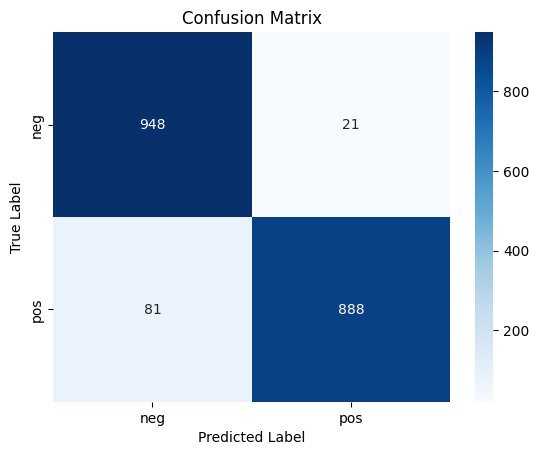

In [ ]:
encoded_labels = [0, 1]  # where 0 corresponds to 'neg' and 1 corresponds to 'pos'

# Generate the confusion matrix using the encoded labels
cm = confusion_matrix(df_processed['label_encoded'], df_processed['sentiment_encoded'], labels=encoded_labels)

# Plotting using Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
df_processed.to_csv('df_processed.csv', index=False)
